! pip install sktime

In [1]:
import requests
from bs4 import BeautifulSoup
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from sktime.forecasting.arima import AutoARIMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sktime.forecasting.model_selection import temporal_train_test_split
import statsmodels.api as sm
from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.tsa.statespace import sarimax
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sktime.forecasting.base import ForecastingHorizon
warnings.filterwarnings('ignore')

In [2]:
# Step 1: Connect to Google Drive
drive.mount('/content/drive')
target_folder = "/content/drive/Shared drives/Time Series/Data/Original"

# Load in df

In [3]:
df = pd.read_csv("/content/drive/Shared drives/Time Series/divvy_data/divvy_data.csv")
df

,rideable_type,date,start_station_name,rides
0,classic_bike,2020-12-02,900 W Harrison St,1
1,classic_bike,2020-12-02,Aberdeen St & Jackson Blvd,1
2,classic_bike,2020-12-02,Albany Ave & Montrose Ave,1
3,classic_bike,2020-12-02,Ashland Ave & 13th St,1
4,classic_bike,2020-12-02,Ashland Ave & Augusta Blvd,2
...,...,...,...,...
1983846,electric_scooter,2024-09-30,Wood St & Hubbard St,8
1983847,electric_scooter,2024-09-30,Wood St & Milwaukee Ave,2
1983848,electric_scooter,2024-09-30,Wood St & Taylor St (Temp),2
1983849,electric_scooter,2024-09-30,Woodlawn Ave & 55th St,1


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
rides,1983851.0,11.559518,17.946354,1.0,2.0,5.0,14.0,731.0


In [5]:
df.dtypes

rideable_type         object
date                  object
start_station_name    object
rides                  int64
dtype: object

### Ride Count Time Series  Plot

In [6]:
# converitng date to datetime format
df['date'] = pd.to_datetime(df['date'])

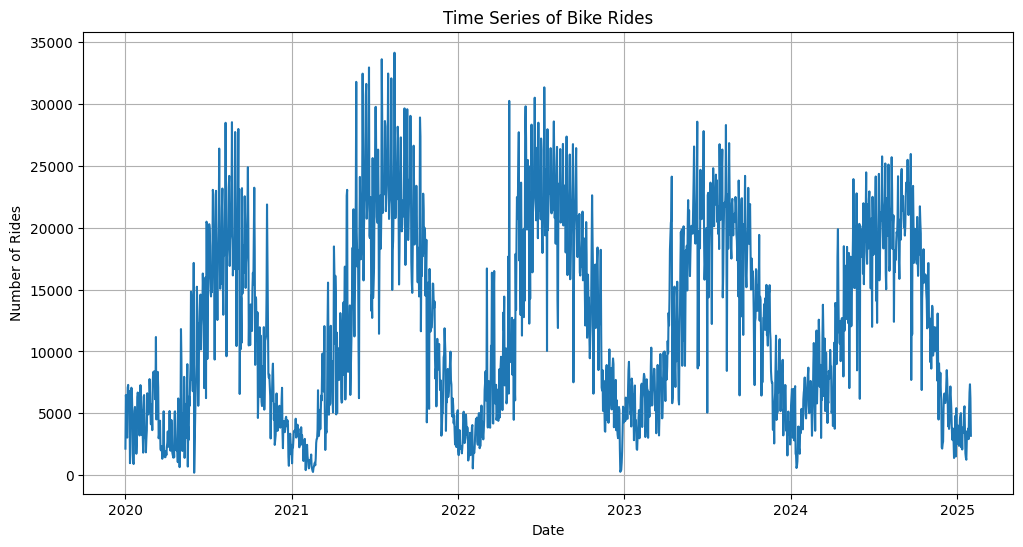

In [7]:
rides_by_date = df.groupby('date')['rides'].sum()

# Create the time series plot
plt.figure(figsize=(12, 6))
plt.plot(rides_by_date.index, rides_by_date.values)
plt.xlabel('Date')
plt.ylabel('Number of Rides')
plt.title('Time Series of Bike Rides')
plt.grid(True)
plt.show()

In [8]:
rides_by_date

date
2020-01-01    2141
2020-01-02    6479
2020-01-03    5890
2020-01-04    3187
2020-01-05    3035
              ... 
2025-01-27    5084
2025-01-28    6677
2025-01-29    7346
2025-01-30    6200
2025-01-31    3180
Name: rides, Length: 1856, dtype: int64

In [9]:
# Train Test Split (Test set is 2024 onwards)
df_train = rides_by_date[rides_by_date.index < '2024-01-01']
df_test = rides_by_date[rides_by_date.index >= '2024-01-01']

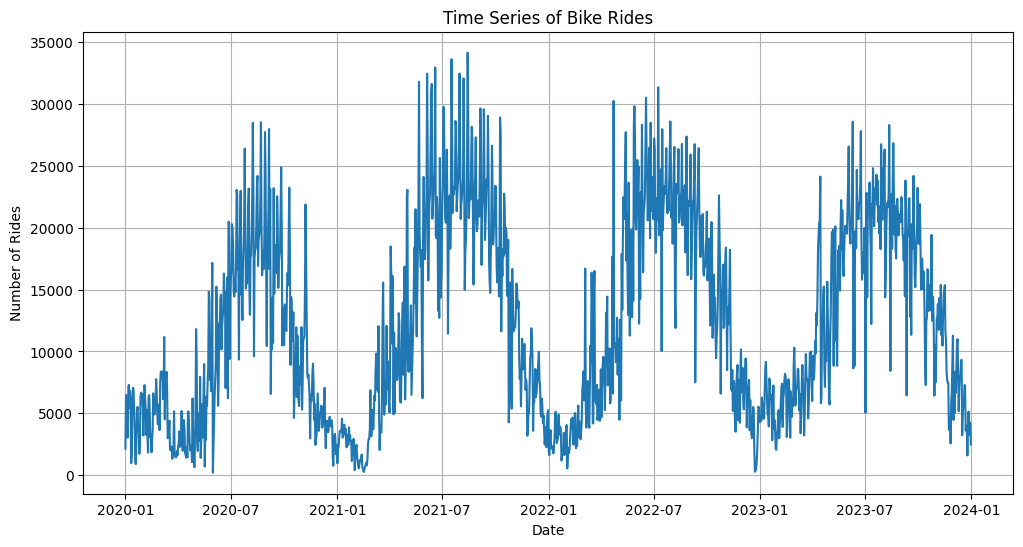

In [10]:
# Plot the training data time series
plt.figure(figsize=(12, 6))
plt.plot(df_train.index, df_train.values)
plt.xlabel('Date')
plt.ylabel('Number of Rides')
plt.title('Time Series of Bike Rides')
plt.grid(True)
plt.show()

In [11]:
import warnings
warnings.filterwarnings('ignore')

# ADF test
adf_result = adfuller(df_train.values)
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])

# KPSS test
kpss_result = kpss(df_train.values, regression='c')
print('KPSS Statistic:', kpss_result[0])
print('p-value:', kpss_result[1])

ADF Statistic: -1.9505771214200895
p-value: 0.308654530141391
KPSS Statistic: 0.4755417140478452
p-value: 0.047175289628863706


Not stationary. Need to Difference.

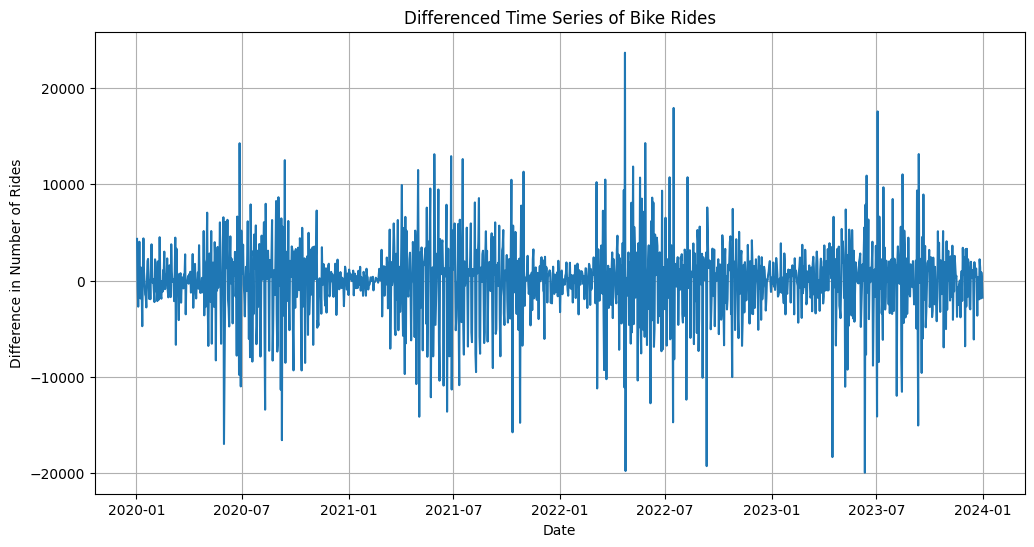

ADF Statistic (Differenced): -10.109325675387996
p-value (Differenced): 1.0100885680795754e-17
KPSS Statistic (Differenced): 0.08749425403766303
p-value (Differenced): 0.1


In [12]:
df_train_diff = df_train.diff().dropna()

# Plot the differenced training data
plt.figure(figsize=(12, 6))
plt.plot(df_train_diff.index, df_train_diff.values)
plt.xlabel('Date')
plt.ylabel('Difference in Number of Rides')
plt.title('Differenced Time Series of Bike Rides')
plt.grid(True)
plt.show()

# ADF test on differenced data
adf_result_diff = adfuller(df_train_diff.values)
print('ADF Statistic (Differenced):', adf_result_diff[0])
print('p-value (Differenced):', adf_result_diff[1])

# KPSS test on differenced data
kpss_result_diff = kpss(df_train_diff.values, regression='c')
print('KPSS Statistic (Differenced):', kpss_result_diff[0])
print('p-value (Differenced):', kpss_result_diff[1])

First difference makes it stationary

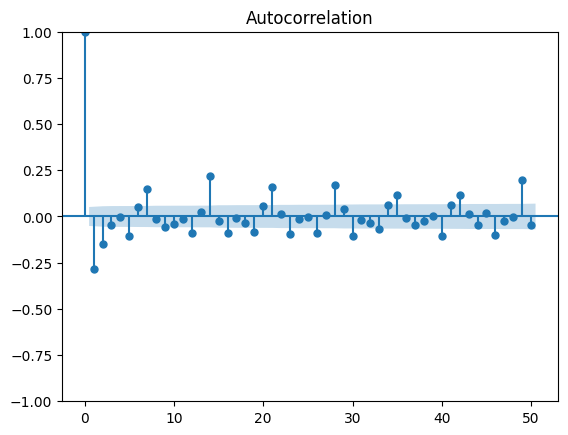

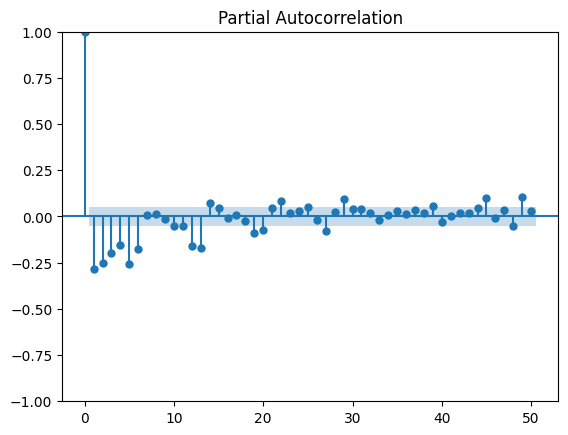

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Assuming df_train_diff is your differenced training data
plot_acf(df_train_diff.values, lags=50)
plt.show()

plot_pacf(df_train_diff.values, lags=50)
plt.show()

- (p,d,q)=(6,1,2)

### ARIMA Model

In [14]:
arima_model = ARIMA(df_train.values, order=(6, 1, 2))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1459
Model:                 ARIMA(6, 1, 2)   Log Likelihood              -13953.950
Date:                Tue, 11 Feb 2025   AIC                          27925.900
Time:                        22:24:40   BIC                          27973.463
Sample:                             0   HQIC                         27943.644
                               - 1459                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4688      0.226     -2.070      0.038      -0.913      -0.025
ar.L2         -0.5347      0.068     -7.917      0.000      -0.667      -0.402
ar.L3         -0.4285      0.067     -6.434      0.000      -0.559      -0.298
ar.L4         -0.3522      0.055     -6.435      0.000      -0.459      -0.245
ar.L5         -0.3436      0.043     -8.060      0.000      -0.427      -0.260
ar.L6         -0.1728      0.048     -3.602      0.000      -0.267      -0.079
ma.L1         -0.0504      0.228     -0.221      0.825      -0.496       0.396
ma.L2          0.0814      0.134      0.607      0.544      -0.182       0.344
sigma2      1.207e+07   2.75e+05     43.814      0.000    1.15e+07    1.26e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               875.66
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.09   Skew:                            -0.16
Prob(H) (two-sided):                  0.35   Kurtosis:                         6.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.2e+14. Standard errors may be unstable.
"""

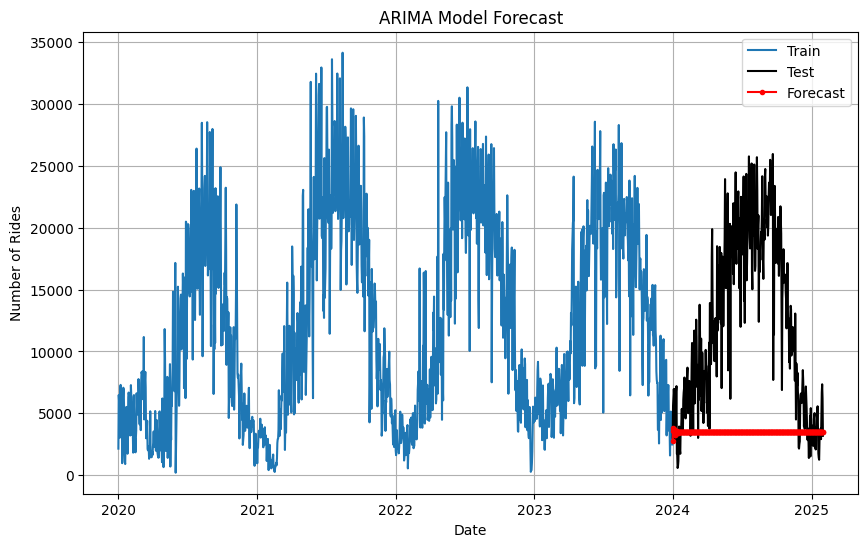

In [15]:
# Forecast
y_pred = arima_model_fit.predict(start=len(df_train), end=len(df_train) + len(df_test) - 1)
y_test = df_test.values

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df_train.index, df_train.values, label='Train')
plt.plot(df_test.index, y_test, color='black', label='Test')
plt.plot(df_test.index, y_pred, color='red', marker='.', label='Forecast')
plt.legend()
plt.title('ARIMA Model Forecast')  # Add a title for clarity
plt.xlabel('Date')
plt.ylabel('Number of Rides')
plt.grid(True)  # Add a grid for better visualization
plt.show()

In [16]:
from sktime.performance_metrics.forecasting import (
    MeanAbsoluteError,
    MeanSquaredError,
    MeanAbsolutePercentageError,
    MeanAbsoluteScaledError
)

# Calculate metrics
mae = MeanAbsoluteError()
mse = MeanSquaredError()
mape = MeanAbsolutePercentageError()
smape = MeanAbsolutePercentageError(symmetric=True)
mase = MeanAbsoluteScaledError()

y_train = df_train.values

print("MAE:", mae(y_test, y_pred))
print("MSE:", mse(y_test, y_pred))
print("MAPE:", mape(y_test, y_pred))
print("SMAPE:", smape(y_test, y_pred))
print("MASE:", mase(y_train=y_train, y_true=y_test, y_pred=y_pred))

MAE: 9096.637586318197
MSE: 127253356.03429784
MAPE: 0.656549422834111
SMAPE: 0.966056650406857
MASE: 3.3047468573396146


Seasonal differencing

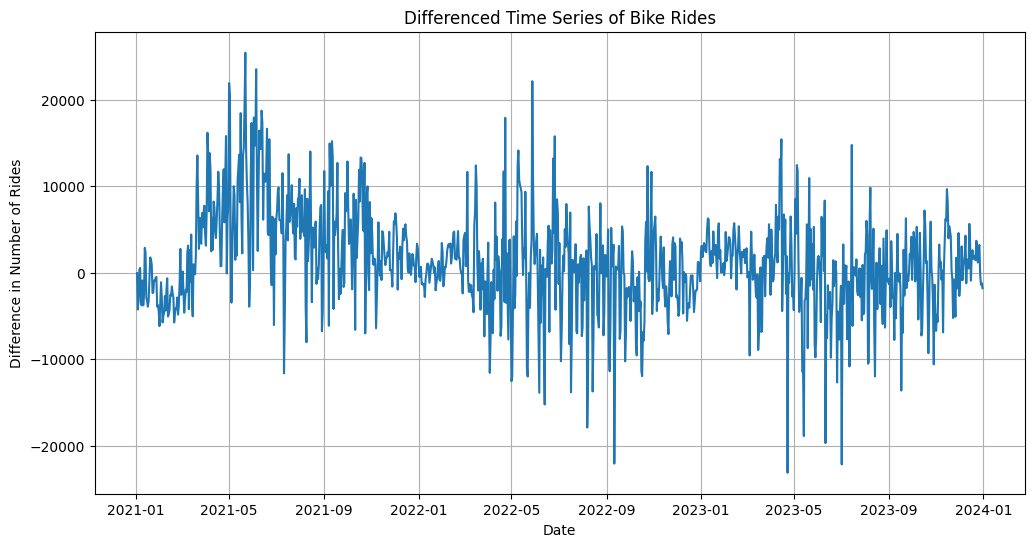

ADF Statistic (Differenced): -3.004679219408871
p-value (Differenced): 0.03445972469964175
KPSS Statistic (Differenced): 1.8029242877819789
p-value (Differenced): 0.01


In [17]:
df_train_seasonal_diff = df_train.diff(365).dropna()

# Plot the differenced training data
plt.figure(figsize=(12, 6))
plt.plot(df_train_seasonal_diff.index, df_train_seasonal_diff.values)
plt.xlabel('Date')
plt.ylabel('Difference in Number of Rides')
plt.title('Differenced Time Series of Bike Rides')
plt.grid(True)
plt.show()

# ADF test on differenced data
adf_result_diff = adfuller(df_train_seasonal_diff.values)
print('ADF Statistic (Differenced):', adf_result_diff[0])
print('p-value (Differenced):', adf_result_diff[1])

# KPSS test on differenced data
kpss_result_diff = kpss(df_train_seasonal_diff.values, regression='c')
print('KPSS Statistic (Differenced):', kpss_result_diff[0])
print('p-value (Differenced):', kpss_result_diff[1])

Now it is difference stationary after yearly difference.

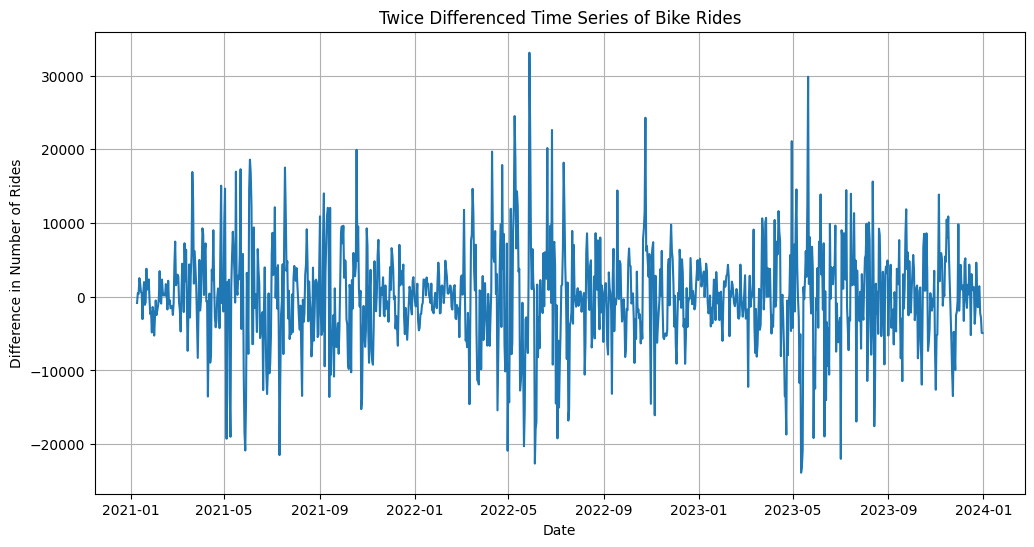

ADF Statistic (Twice Differenced): -8.679697370228961
p-value (Twice Differenced): 4.319477172674514e-14
KPSS Statistic (Twice Differenced): 0.017625203144651505
p-value (Twice Differenced): 0.1


In [18]:
# Second differencing (weekly)
df_train_seasonal_diff_2 = df_train_seasonal_diff.diff(7).dropna()

# Plot the twice differenced training data
plt.figure(figsize=(12, 6))
plt.plot(df_train_seasonal_diff_2.index, df_train_seasonal_diff_2.values)
plt.xlabel('Date')
plt.ylabel('Difference in Number of Rides')
plt.title('Twice Differenced Time Series of Bike Rides')
plt.grid(True)
plt.show()

# ADF test on twice differenced data
adf_result_diff_2 = adfuller(df_train_seasonal_diff_2.values)
print('ADF Statistic (Twice Differenced):', adf_result_diff_2[0])
print('p-value (Twice Differenced):', adf_result_diff_2[1])

# KPSS test on twice differenced data
kpss_result_diff_2 = kpss(df_train_seasonal_diff_2.values, regression='c')
print('KPSS Statistic (Twice Differenced):', kpss_result_diff_2[0])
print('p-value (Twice Differenced):', kpss_result_diff_2[1])

Now it is stationary

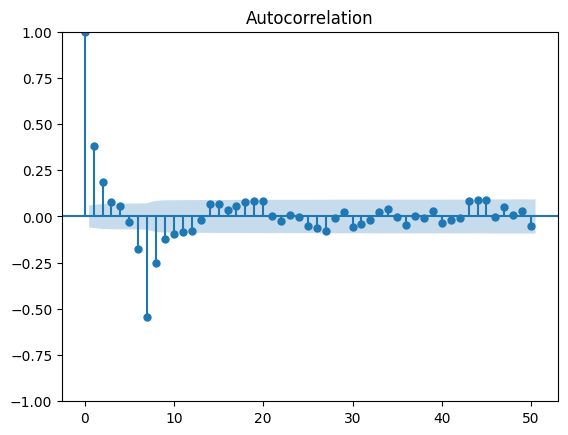

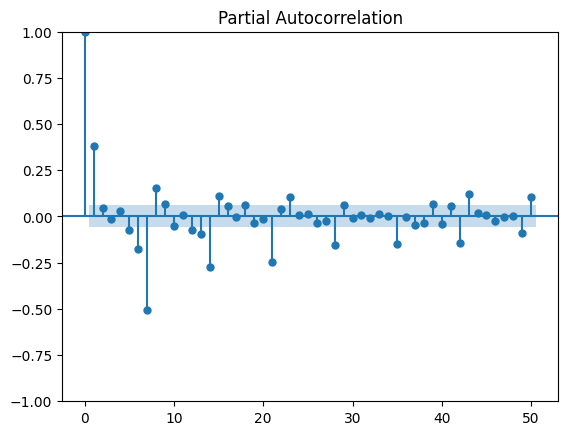

In [19]:
plot_acf(df_train_seasonal_diff_2.values, lags=50)
plt.show()

plot_pacf(df_train_seasonal_diff_2.values, lags=50)
plt.show()

(P,D,Q)=(1,1,1)?

### Sarima Model

In [20]:
# Train Test Split (need to make train size smaller because running into RAM issues for this SARIMA model (m=365))
df_train_sarima = rides_by_date[(rides_by_date.index < '2024-01-01')]
df_test_sarima = rides_by_date[rides_by_date.index >= '2024-01-01']

In [21]:
sarima_model = SARIMAX(df_train_sarima.values, order=(0, 0, 0), seasonal_order=(0, 1, 0, 365))
sarima_model_fit = sarima_model.fit()
print(sarima_model_fit.summary())

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.59940D+00    |proj g|=  4.84632D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      6      1     0     0   9.347D-06   7.583D+00
  F =   7.5831806125218879     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                 SARIMAX Results                                 
Dep. Variable:                         y   No. Observations:                 1459
Model:             SARIMAX(0, 

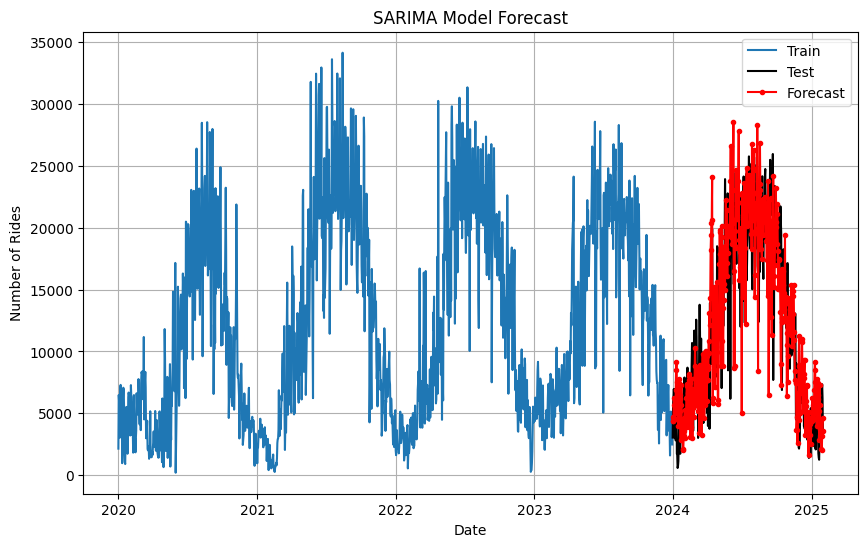

In [22]:
# Forecast
y_pred_sarima = sarima_model_fit.predict(start=len(df_train_sarima), end=len(df_train_sarima) + len(df_test_sarima) - 1)
y_test_sarima = df_test_sarima.values

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df_train_sarima.index, df_train_sarima.values, label='Train')
plt.plot(df_test_sarima.index, y_test_sarima, color='black', label='Test')
plt.plot(df_test_sarima.index, y_pred_sarima, color='red', marker='.', label='Forecast')
plt.legend()
plt.title('SARIMA Model Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Rides')
plt.grid(True)  # Add a grid for better visualization
plt.show()

In [23]:
# Calculate metrics
mae = MeanAbsoluteError()
mse = MeanSquaredError()
mape = MeanAbsolutePercentageError()
smape = MeanAbsolutePercentageError(symmetric=True)
mase = MeanAbsoluteScaledError()

y_train_sarima = df_train_sarima.values

print("MAE:", mae(y_test_sarima, y_pred_sarima))
print("MSE:", mse(y_test_sarima, y_pred_sarima))
print("MAPE:", mape(y_test_sarima, y_pred_sarima))
print("SMAPE:", smape(y_test_sarima, y_pred_sarima))
print("MASE:", mase(y_train=y_train_sarima, y_true=y_test_sarima, y_pred=y_pred_sarima))

MAE: 3203.463476070529
MSE: 18693134.516372796
MAPE: 0.4359376025134116
SMAPE: 0.3312796542832589
MASE: 1.163796595685988


Prophet Model

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from prophet import Prophet

# Prepare the data for Prophet
df_prophet_train = df_train.reset_index()
df_prophet_train.columns = ['ds', 'y']

df_prophet_test = df_test.reset_index()
df_prophet_test.columns = ['ds', 'y']

15:13:24 - cmdstanpy - INFO - Chain [1] start processing
15:13:24 - cmdstanpy - INFO - Chain [1] done processing


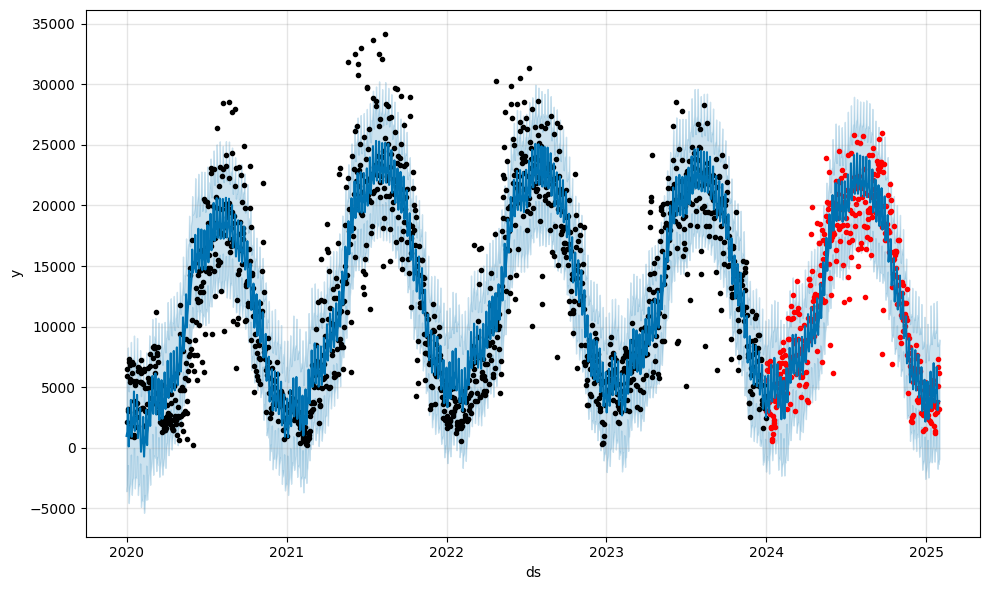

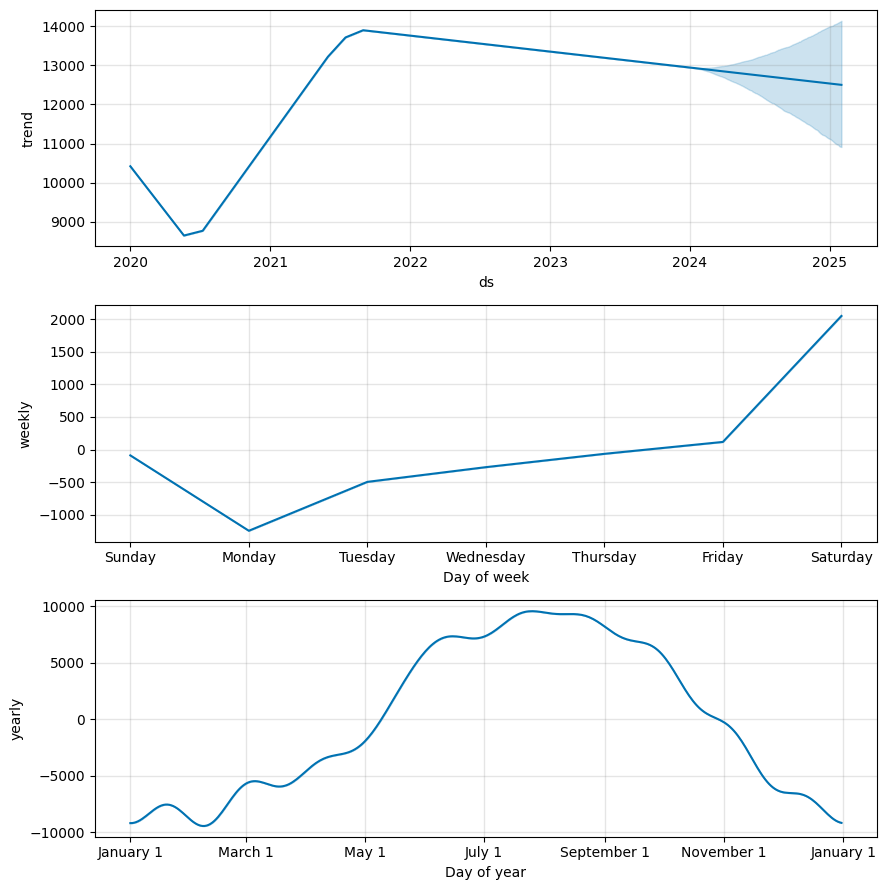

In [31]:
# Create and fit the Prophet model
model = Prophet()
model.fit(df_prophet_train)

# Create future dates for prediction
future = model.make_future_dataframe(periods=len(df_test), freq='D')

# Make predictions
forecast_data = model.predict(future)

# Plot the results
fig = model.plot(forecast_data)
plt.scatter(pd.to_datetime(df_prophet_test['ds']), pd.to_numeric(df_prophet_test['y']), color='r', marker='.')
plt.show()

# Plot components
fig_components = model.plot_components(forecast_data)
plt.show()

In [32]:
from sktime.performance_metrics.forecasting import (
    MeanAbsoluteError,
    MeanSquaredError,
    MeanAbsolutePercentageError,
    MeanAbsoluteScaledError
)

# Calculate metrics
mae = MeanAbsoluteError()
mse = MeanSquaredError()
mape = MeanAbsolutePercentageError()
smape = MeanAbsolutePercentageError(symmetric=True)
mase = MeanAbsoluteScaledError()

y_train = df_train.values
y_pred = forecast_data['yhat'].values[-len(df_test):]

print("MAE:", mae(y_test, y_pred))
print("MSE:", mse(y_test, y_pred))
print("MAPE:", mape(y_test, y_pred))
print("SMAPE:", smape(y_test, y_pred))
print("MASE:", mase(y_train=y_train, y_true=y_test, y_pred=y_pred))

MAE: 2414.4325646078896
MSE: 9781558.672101347
MAPE: 0.3474171178626463
SMAPE: 0.2783162805742586
MASE: 0.8771470067299705


In [27]:
forecast_data

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-01,10421.728200,-4128.466020,5179.749193,10421.728200,10421.728200,-9457.921103,-9457.921103,-9457.921103,-270.240300,-270.240300,-270.240300,-9187.680803,-9187.680803,-9187.680803,0.0,0.0,0.0,963.807097
1,2020-01-02,10409.083729,-3733.898362,5915.295754,10409.083729,10409.083729,-9264.723587,-9264.723587,-9264.723587,-65.680632,-65.680632,-65.680632,-9199.042956,-9199.042956,-9199.042956,0.0,0.0,0.0,1144.360142
2,2020-01-03,10396.439258,-3420.004495,6026.248338,10396.439258,10396.439258,-9068.876352,-9068.876352,-9068.876352,117.156135,117.156135,117.156135,-9186.032487,-9186.032487,-9186.032487,0.0,0.0,0.0,1327.562906
3,2020-01-04,10383.794788,-1183.491022,8242.813467,10383.794788,10383.794788,-7097.740564,-7097.740564,-7097.740564,2051.572628,2051.572628,2051.572628,-9149.313192,-9149.313192,-9149.313192,0.0,0.0,0.0,3286.054223
4,2020-01-05,10371.150317,-3133.541434,5735.802754,10371.150317,10371.150317,-9179.728754,-9179.728754,-9179.728754,-89.575582,-89.575582,-89.575582,-9090.153172,-9090.153172,-9090.153172,0.0,0.0,0.0,1191.421563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1851,2025-01-27,12504.728354,-1766.743487,8220.447334,10923.416716,14203.512077,-9410.519004,-9410.519004,-9410.519004,-1247.025735,-1247.025735,-1247.025735,-8163.493270,-8163.493270,-8163.493270,0.0,0.0,0.0,3094.209350
1852,2025-01-28,12503.612081,-1600.287182,8607.789919,10912.780030,14209.729702,-8809.931883,-8809.931883,-8809.931883,-496.206514,-496.206514,-496.206514,-8313.725369,-8313.725369,-8313.725369,0.0,0.0,0.0,3693.680198
1853,2025-01-29,12502.495807,-1474.182226,8689.524750,10898.475115,14217.412154,-8739.919202,-8739.919202,-8739.919202,-270.240300,-270.240300,-270.240300,-8469.678901,-8469.678901,-8469.678901,0.0,0.0,0.0,3762.576605
1854,2025-01-30,12501.379533,-1351.557231,8402.346429,10887.794629,14222.917151,-8692.835557,-8692.835557,-8692.835557,-65.680632,-65.680632,-65.680632,-8627.154925,-8627.154925,-8627.154925,0.0,0.0,0.0,3808.543977
